In [69]:
# NIVELL 1 - EXERCICI 1:
# Connecta Python amb MySQL Workbench i carrega les dades de la teva base de dades del Sprint 4 per utilitzar-les en tots els exercicis.

import pymysql
import pandas as pd
conexión = pymysql.connect(host= "127.0.0.1", user= "root", passwd= "Pedito-1520", database= "sprint4_bis")

try:
    cursor = conexión.cursor()

    # Obtenim la llista de taules
    cursor.execute("SHOW TABLES")
    taules = [fila[0] for fila in cursor.fetchall()]

    # Diccionari per guardar les dades de cada taula com a DataFrame
    dades = {}
    for taula in taules:
        df = pd.read_sql(f"SELECT * FROM `{taula}`", conexión)
        dades[taula] = df
        print(f"Taula '{taula}' carregada amb {len(df)} files.")

finally:
    conexión.close()

C:\Users\joanr\AppData\Local\Temp\ipykernel_14460\1246375766.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM `{taula}`", conexión)


Taula 'companies' carregada amb 100 files.
Taula 'credit_cards' carregada amb 5000 files.
Taula 'estado_tarjetas' carregada amb 5000 files.
Taula 'products' carregada amb 100 files.
Taula 'transaction_product' carregada amb 253391 files.
Taula 'transactions' carregada amb 100000 files.
Taula 'users_all' carregada amb 5000 files.


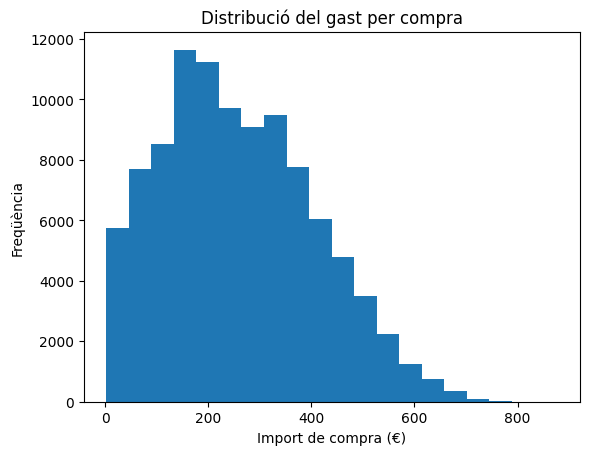

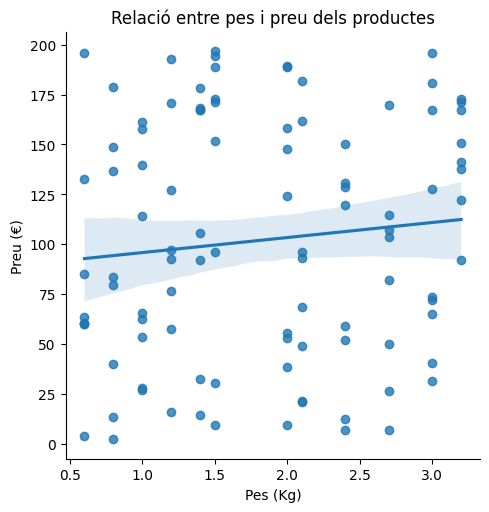

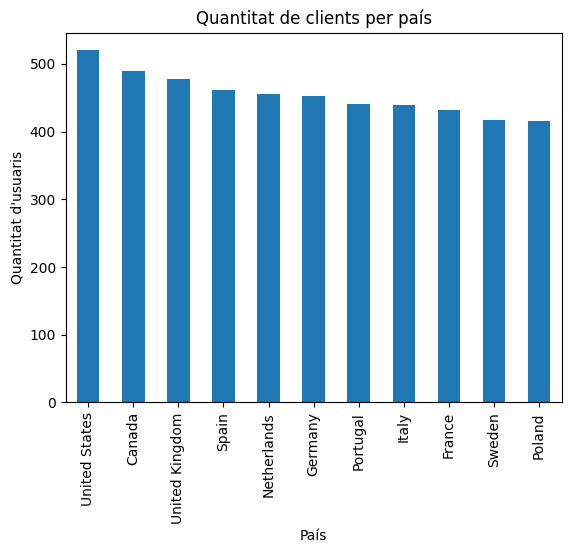

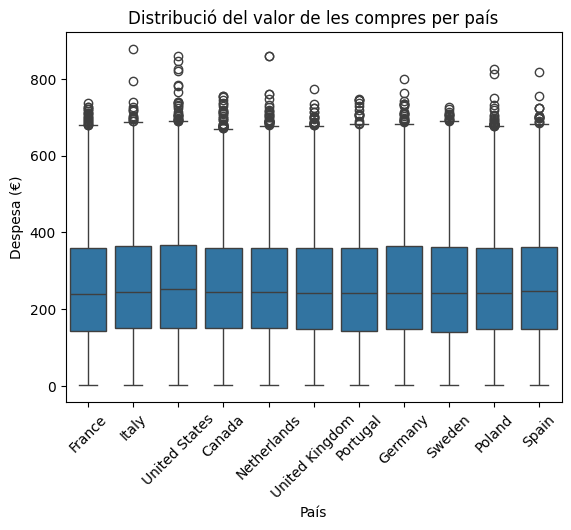

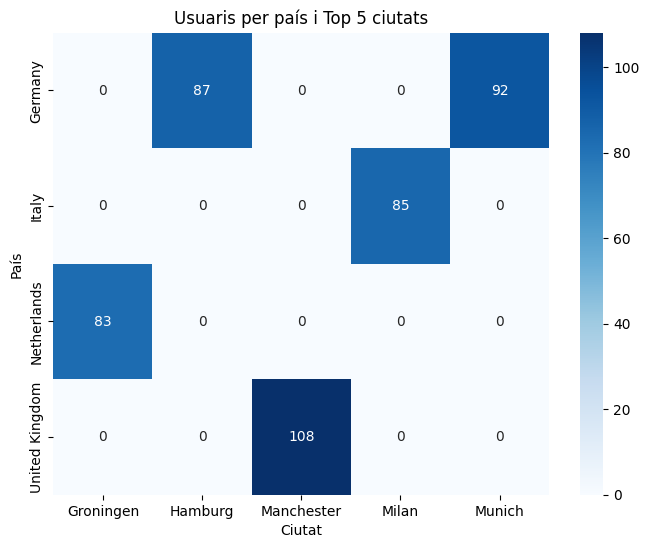

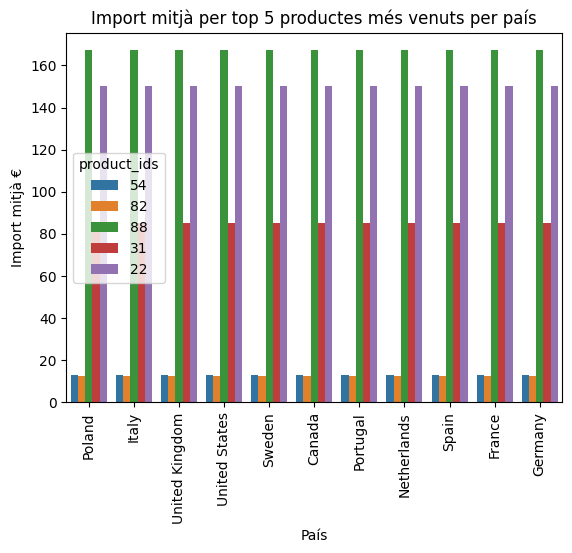

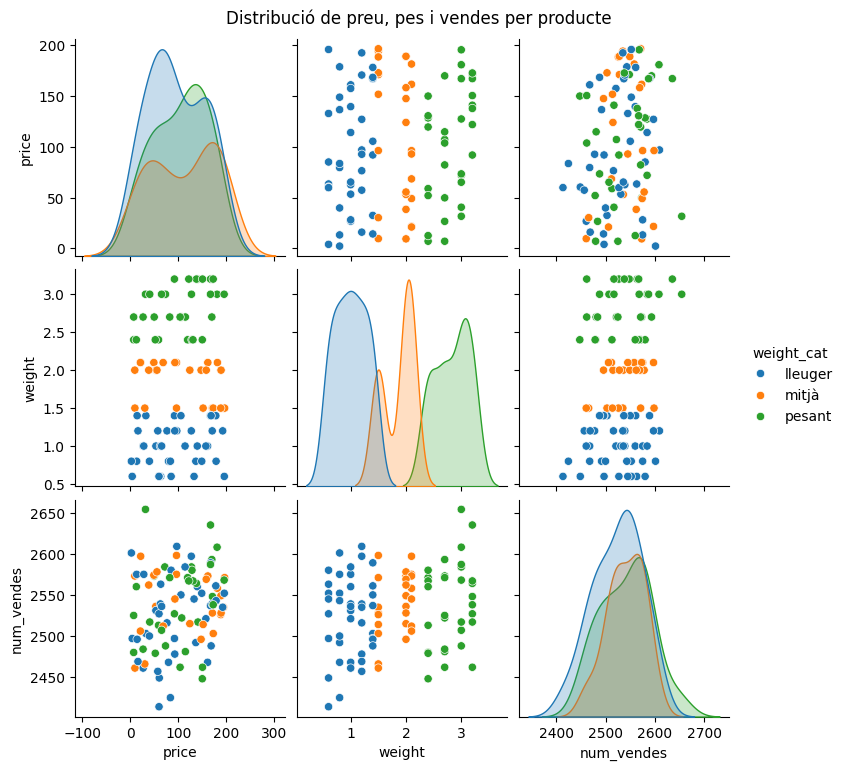

In [70]:
# EXERCICI 2:  Per a cada ítem, crea una visualització adequada segons les variables especificades. 
# Interpreta els resultats segons les teves dades.

import matplotlib.pyplot as plt 
import seaborn as sns

# Una variable numèrica.
df_transactions = dades["transactions"]
df_transactions["amount"].plot.hist(bins = 20)
plt.title("Distribució del gast per compra")
plt.xlabel("Import de compra (€)")
plt.ylabel("Freqüència")
plt.show()

# Dues variables numèriques.
df_products = dades["products"].copy()

    # Eliminar el símbol $ i convertir a numèric
df_products["price"] = df_products["price"].str.replace("$", "", regex=False)
df_products["price"] = pd.to_numeric(df_products["price"])

    # fem el gràfic
sns.lmplot(data= df_products, x= "weight", y= "price")
plt.title("Relació entre pes i preu dels productes")
plt.xlabel("Pes (Kg)")
plt.ylabel("Preu (€)")
plt.show()

# Una variable categòrica
df_users_all = dades["users_all"]
df_users_all["country"].value_counts().plot.bar()
plt.title("Quantitat de clients per país")
plt.xlabel ("País")
plt.ylabel("Quantitat d'usuaris")
plt.show()

# Una variable numèrica i una categòrica
merged = df_transactions.merge(df_users_all, left_on="user_id", right_on="id")
sns.boxplot(data=merged, x="country", y="amount")
plt.xticks(rotation=45)
plt.title("Distribució del valor de les compres per país")
plt.ylabel("Despesa (€)")
plt.xlabel("País")
plt.show()

# Dues variables categòriques.

top_cities = df_users_all["city"].value_counts().head(5).index
df_users_all["city"] = df_users_all["city"].where(df_users_all["city"].isin(top_cities))

ct = pd.crosstab(df_users_all["country"], df_users_all["city"])
plt.figure(figsize=(8,6))
sns.heatmap(ct, cmap="Blues", annot=True, fmt="d")
plt.title("Usuaris per país i Top 5 ciutats")
plt.xlabel("Ciutat")
plt.ylabel("País")
plt.show()


# Tres variables combinades.
top_products = merged["product_ids"].value_counts().head(5).index
df_top = merged[merged["product_ids"].isin(top_products)]
names = df


sns.barplot(data=df_top, x="country", y= "amount", hue="product_ids", estimator= "mean")
plt.title("Import mitjà per top 5 productes més venuts per país")
plt.ylabel("Import mitjà €")
plt.xlabel("País")
plt.xticks(rotation=90)
plt.show()



# Crea un Pairplot.

# Assignem categories de pes als productes
df_products["weight_cat"] = pd.cut(df_products["weight"], bins=3, labels=["lleuger","mitjà","pesant"])

# Comptem quantes vegades apareix cada producte
sales_count = df_trans_prod.groupby("product_id")["transaction_id"].count().reset_index()

# Canviem el nom de la columna per claredat
sales_count.rename(columns={"transaction_id": "num_vendes"}, inplace=True)

# Ara unim amb df_products per afegir aquesta informació
df_products_sales = df_products.merge(sales_count, left_on="id", right_on="product_id", how="left")

# Afegim el pairplot, amb les variables, preu, pes i el producte i nombre de vegades venut
sns.pairplot(
    df_products_sales, 
    vars=["price", "weight", "num_vendes"], 
    hue="weight_cat")
plt.suptitle("Distribució de preu, pes i vendes per producte", y=1.02)
plt.show()


In [71]:
# INTERPRETACIÓ DE LES GRÀFIQUES - EXERCICI 2 (NIVELL 1)

# Una variable numèrica:
 
# La primera gràfica ens mostra la distribució del gast per compra dels usuaris clients. 
# Observem que la distribució té forma de campana, amb certa skewness cap a la dreta (marca que hi ha moltes compres petites o mitjanes i poques compres amb imports alts). 
# El rang més freqüent entre els clients són les compres entre 100 i 300€ (presenten una freqüència superior, hi ha més de 10000 compres)
# A partir de 300-400 €, la freqüència comença a baixar progressivament
# A partir dels 600€, les compres ja són molt menys habituals (freqüències inferiors a 2000)

# Dues variables numèriques:

# La línia de regressió té un lleuger pendent positiu, indicant que a mesura que el pes del producte augmenta, augmenta el preu.
# Igualment, la correlació és massa dèbil com per afirmar que el preu depèn del pes, perquè trobem molts productes de pes elevat amb preus baixos.
# A més la dispersió de les dades és força elevada, per tant podem concloure que no hi ha una clara correlació entre el pes i el preu del prodcute.

#  Una variable categòrica:

# Observem que els clients que fan transaccions provenen de 12 països diferents, sent Estats Units el país amb major nombre de clients (amb més de 500), seguit de Canadà (amb menys de 500)
# Espanya es troba en el top 4 (amb uns 450 clients) i el país amb un nombre inferior és Polònia (amb poc més de 400)
# Com observem, no hi ha grans diferències entre el nombre de clients per país. Tots es troben entre 400 i 500 persones.

# Una variable numèrica i una categòrica:

# Mitjançant el barplot, observem que la mediana (linia dins la caixa), mostra entre 220 i 250 € en tots els països de despesa mitjana, sent Estats Units el país amb mediana més elevada.
# La caixa, rang interquartílic ens diu que la majoria de compres es troben entre 150-350€.
# Els bigotis de les caixes ens mostren els valors 1,5 vegades el rang interquartílic, mostrant des de 0 fins a uns 700€ de despesa
# Amb els outliers, observem que hi ha compres excepcionals (per sobre dels 800€) 
# Quan comparem entre països, observem que tant la mitjana com els outliers de les compres són prou similars, donant-nos diferències poc significatives.

# Dues variables categòriques:

# Alemanya té la major part d'usuaris entre Hamburg amb 87 i Munich 92 usuaris.
# Itàlia només té una ciutat en el top: Milan amb 85 usuaris.
# Països Baixos té Groningen amb 83 usuaris.
# Per últim, Regne Unit té la ciutat amb més usuaris del gràfic: Manchester amb 108.
# Amb aquest gràfic mostrem en quines ciutats dels països amb més clients es concentren els usuaris. (fent top 5)

# Tres variables combinades:

# El producte amb ID 88 (barra verda) és el producte que té un import mitjà més elevat en tots els països que el compren (entre 165 i 170 €), 
# Seguit d'aquest, trobem el 22 amb un import d'uns 150€
# El producte 31 es troba en compres per uns 85€, i els 54 i 82 per uns 10 o 15€, els més econòmics.
# Les diferències entre països són gairebé imperceptibles, els imports mitjans són pràcticament els mateixos, independentment del país. 
# No podem trobar patrons de preferències de productes per país.

# Pairplot:

# Podem observar que els productes lleugers i mitjans tenen preus més variats, mentre que els pesants es concentren en preus intermitjos (entre 100 i 150€)
# Respecte el nombre de vendes, observem q la distribució és similar per les tres categories, el nombre de vendes no depèn del pes.
# Relació preu - pes: com hem vista anteriorment, no hi ha una correlació cara, els prodcutes pesants no són els més cars.
# Relació preu - nombre de vendes: els punts es troben molt escampats, el preu no té efecte aparent en el nombre de vendes.
# Relació pes - nombre de vendes: tampoc observem una dependència clara, per les tres categories de pes trobem distribucions de vendes molt similars.

# Conclusió final: ni el pes ni el preu del producte es troben relacionats amb el nombre de vendes. Potser caldria tenir en compte altres variables per analitzar si hi ha algun patró.


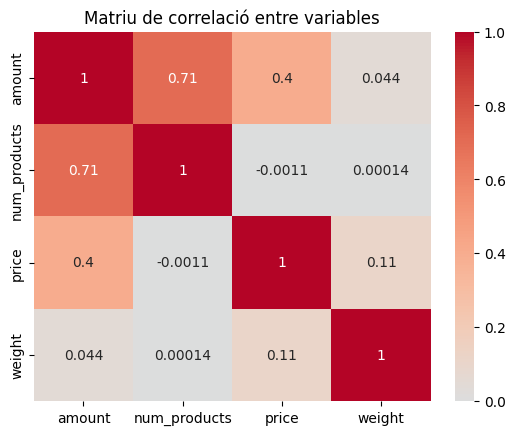

In [72]:
# NIVELL 2 - EXERCICI 1: Representa la correlació d'algunes variables i interpreta els resultats segons les teves dades.

df_trans_prod = dades["transaction_product"]

# Afegim nombre de productes per transacció
prod_count = df_trans_prod.groupby("transaction_id")["product_id"].count().reset_index()
prod_count.rename(columns={"product_id":"num_products"}, inplace=True)

# Merge
merged = df_transactions.merge(prod_count, left_on="id", right_on="transaction_id")
merged = merged.merge(df_trans_prod, left_on="id", right_on="transaction_id")
merged = merged.merge(df_products, left_on="product_id", right_on="id")

# Variables d'interès
num_vars = ["amount", "num_products", "price", "weight"]
corr = merged[num_vars].corr()

# Heatmap de correlacions
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriu de correlació entre variables")
plt.show()


# hi ha una relació positiva en quant al preu de producte i el nombre de productes comprats amb l'amount gastat.
# També hi ha correlació, encara que menys notable amb el pes del producte comprat i l'amount gastat. 




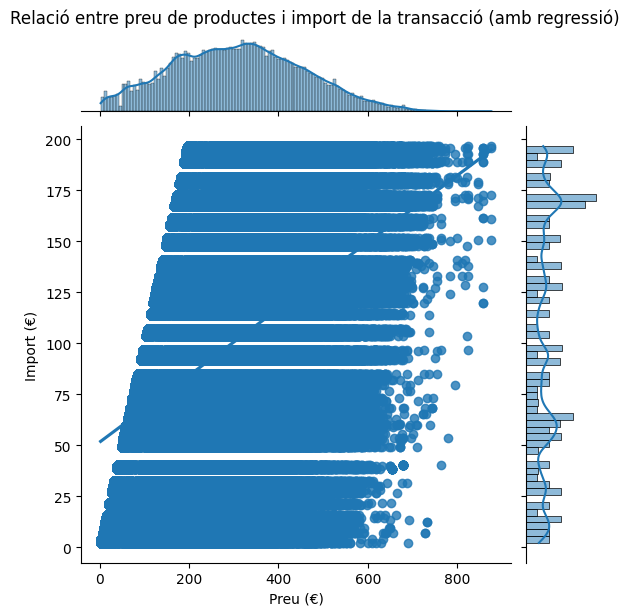

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Jointplot amb regressió lineal
g = sns.jointplot(data=merged, x="amount", y="price", kind="reg")

# Afegim títol (important: usar g.fig.suptitle)
g.fig.suptitle("Relació entre preu de productes i import de la transacció (amb regressió)", y=1.02)
plt.xlabel("Preu (€)")
plt.ylabel("Import (€)")
plt.show()



# Com era d’esperar, a mesura que puja el preu del producte, els imports de les transaccions també solen ser més elevats.
# Encara que hi ha correlació, la dispersió és gran, hi ha productes barats (p. ex. 10 €) que generen imports alts → es deuen a compres amb molts productes barats.
# Per altra banda, hi ha productes cars (p. ex. 200 €) en transaccions amb imports relativament baixos → pot ser perquè es compren poques unitats.

In [74]:
# NIVELL 3 - EXERCICI 1: Transfereix totes les visualitzacions del Nivell 1 a Power BI utilitzant scripts de Python.

# en PBI adjunto, sprint 11.pbix
